In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, welch, savgol_filter, spectrogram, stft, hilbert, hilbert2, detrend
from scipy.stats import skew, kurtosis
from scipy.fft import fft2

In [2]:
FILE_PATH = None
RAW_CSI_RANGES = [slice(12, 64), slice(66, 118), slice(132, 246), slice(254, 368), slice(374, 488), slice(496, 610)]
STEP = 10
PACKET_SET_RANGES = [(i, i + STEP) for i in range(0, 220, STEP)]
STARTING_PACKET = 20
ENDING_PACKET = 30

#### **Base Preprocessing**

In [3]:
def compute_csi_amplitude_phase(raw_csi):
    amplitudes = []
    phases = []
    
    if len(raw_csi) % 2 != 0: raise ValueError('CSI data length must be even.')
    
    for i in range(0, len(raw_csi), 2):
        I = raw_csi[i]
        Q = raw_csi[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    return amplitudes, phases

In [4]:
def load_csi_data(file_path):
    csi_data = pd.read_csv(file_path)
    csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: sum([eval(x)[r] for r in RAW_CSI_RANGES], []))
    csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))
    csi_data.drop(columns=['Raw_CSI'], inplace=True)
    print(f'Dist: {csi_data['Distance'].values[:1]} Angle: {csi_data['Angle'].values[:1]}')
    return csi_data

In [5]:
def plot_line_chart_data_transform(csi_data, is_amplitude, ax, title):
    for idx, packet in enumerate(csi_data[STARTING_PACKET:ENDING_PACKET]):
        ax.plot(range(len(packet)), packet)

    if is_amplitude:
        ax.set_title(f'{title} Amplitude')
        ax.set_ylabel('Amplitude (Magnitude)')
    else:
        ax.set_title(f'{title} Phase')
        ax.set_ylabel('Phase (Radians)')

    ax.set_xlabel('Subcarrier Index')
    ax.grid(True)
    ax.margins(x=0)

In [6]:
def plot_line_chart_feature_extract(csi_packet_set, is_amplitude, ax, title):
    for idx, packet_feature in enumerate(csi_packet_set):
        ax.plot(range(len(packet_feature)), packet_feature)

    if is_amplitude:
        ax.set_title(f'Amplitude {title}')
    else:
        ax.set_title(f'Phase {title}')

    ax.set_xlabel('Subcarrier Index')
    ax.set_ylabel(title)
    ax.grid(True)
    ax.margins(x=0)

#### **Signal Transformation Analysis**

In [7]:
def unwrap_csi_phases(csi_data):
    return csi_data.apply(lambda x: np.unwrap(x))

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [9]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

In [10]:
def butter_highpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#### **Time-Domain Analysis**

In [11]:
def short_time_energy(data):
    return np.sum(np.square(data)) / len(data)

In [12]:
def zero_crossing_rate(data):
    data = np.array(data)
    return np.mean(np.abs(np.diff(np.sign(data))))

In [13]:
def spectrogram_features(data):
    # Ensure data is a 1D array
    data = np.array(data).flatten()
    f, t, Sxx = spectrogram(data, fs=1.0, nperseg=min(64, len(data)), noverlap=32, nfft=128)
    return Sxx.mean(axis=1).tolist()

#### **Frequency-Domain Analysis**

In [14]:
def fast_fourier_transform_1d(data):
    fft_features = []
    for amp in data:
        fft_vals = np.abs(np.fft.fft(amp))
        fft_half = fft_vals[:len(fft_vals)//2]  # Take positive frequencies only
        fft_features.append(fft_half.tolist())
    return fft_features

In [15]:
def fast_fourier_transform_2d(data):
    amp_array = np.array(data).reshape(1, -1)
    fft = np.abs(fft2(amp_array))
    return fft.flatten().tolist()

In [16]:
def wavelet_transform(amplitudes, phases, swt_wavelet, swt_level, iswt_wavelet):
    transformed_amplitudes, transformed_phases = [], []

    for i in range(len(amplitudes)):
        csi_data = [a * np.exp(1j * p) for a, p in zip(amplitudes[i], phases[i])]
        csi_data = pywt.swt(csi_data, swt_wavelet, swt_level)
        csi_data = pywt.iswt(csi_data, iswt_wavelet)

        # Separate amplitude and phase
        transformed_amplitudes.append(np.abs(csi_data))
        transformed_phases.append(np.angle(csi_data))
    
    return transformed_amplitudes, transformed_phases

In [17]:
def power_spectral_entropy(data, fs, nperseg): # TODO: Add important parameters
    # if len(data) < nperseg:
    #     raise ValueError("Data length must be greater than nperseg.")
    freqs = welch(data, fs=fs, nperseg=nperseg, axis=0)
    psd = freqs[1]
    psd = savgol_filter(psd, 51, 3)
    psd = np.abs(psd)
    
    psd_norm = psd / np.sum(psd)
    psd_norm = np.clip(psd_norm, 1e-12, 1)  # Avoid log(0)
    entropy = -np.sum(psd_norm * np.log2(psd_norm))
    return entropy

In [18]:
def stfft_features(data):
    f, t, Zxx = stft(data, fs=1.0, nperseg=min(64, len(data)))
    magnitude = np.abs(Zxx)
    return magnitude.mean(axis=1).tolist()

In [19]:
def hilbert_features(data):
    analytic_signal = hilbert(data)
    signal_envelope = np.abs(analytic_signal)
    return signal_envelope.tolist()

In [20]:
def hilbert2_features(data):
    analytic_signal = hilbert2(data)
    amplitude_envelope = np.abs(analytic_signal)
    
    return amplitude_envelope.tolist()

In [21]:
def detrended_features(data):
    array_2d = np.array(data)
    detrended_signal = detrend(array_2d, axis=1)
    
    return detrended_signal.tolist()

#### **Signal Transformation Visualization**

In [22]:
def visualize_csi_raw(file_path):
    csi_data = load_csi_data(file_path)

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Raw')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Raw')

    plt.tight_layout()
    plt.show()

In [23]:
def visualize_csi_upwrap_averaged(file_path, unwrap_phase=False, amp_avg_win=35, pha_avg_win=1):
    csi_data = load_csi_data(file_path)

    if unwrap_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])
    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: moving_average(x, amp_avg_win))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: moving_average(x, pha_avg_win))
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Moving Averaged')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Unwarped and Moving Averaged')

    plt.tight_layout()
    plt.show()

In [24]:
def visualize_csi_savgol_filter(file_path, window=11, polyorder=3):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: savgol_filter(x, window, polyorder))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: savgol_filter(x, window, polyorder))

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Savitzky-Golay Filtered')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Savitzky-Golay Filtered')

    plt.tight_layout()
    plt.show()

In [25]:
def visualize_csi_lowpass_filter(file_path, cutoff=0.1, fs=1, order=5):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: butter_lowpass_filter(x, cutoff, fs, order))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: butter_lowpass_filter(x, cutoff, fs, order))

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Lowpass Filtered')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Lowpass Filtered')

    plt.tight_layout()
    plt.show()

In [26]:
def visualize_csi_highpass_filter(file_path, cutoff=0.1, fs=1, order=5):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: butter_highpass_filter(x, cutoff, fs, order))
    csi_data['Phases'] = csi_data['Phases'].apply(lambda x: butter_highpass_filter(x, cutoff, fs, order))

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Highpass Filtered')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Highpass Filtered')

    plt.tight_layout()
    plt.show()

#### **Time-Domain Visualization**

In [27]:
def visualize_csi_standard_deviation(file_path, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    
    amplitude_features = [np.std(amplitude_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.std(phase_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Standard Deviation')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Standard Deviation')

    plt.tight_layout()
    plt.show()

In [28]:
def visualize_csi_mean(file_path, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [np.mean(amplitude_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.mean(phase_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Mean')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Mean')

    plt.tight_layout()
    plt.show()

In [29]:
def visualize_csi_variance(file_path, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [np.var(amplitude_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.var(phase_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Variance')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Variance')

    plt.tight_layout()
    plt.show()

In [30]:
def visualize_csi_percentile(file_path, percentile=75, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [np.percentile(amplitude_data[start:end], percentile, axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.percentile(phase_data[start:end], percentile, axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], f'Percentile ({percentile})')
    plot_line_chart_feature_extract(phase_features, False, axs[1], f'Percentile ({percentile})')

    plt.tight_layout()
    plt.show()

In [31]:
def visualize_csi_min(file_path):
    csi_data = load_csi_data(file_path)

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [np.min(amplitude_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.min(phase_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Minimum')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Minimum')

    plt.tight_layout()
    plt.show()

In [32]:
def visualize_csi_max(file_path):
    csi_data = load_csi_data(file_path)

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [np.max(amplitude_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]
    phase_features = [np.max(phase_data[start:end], axis=0) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Maximum')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Maximum')

    plt.tight_layout()
    plt.show()

In [33]:
def visualize_csi_skew(file_path, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [skew(amplitude_data[start:end]) for start, end in PACKET_SET_RANGES]
    phase_features = [skew(phase_data[start:end]) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Skew')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Skew')

    plt.tight_layout()
    plt.show()

In [34]:
def visualize_csi_kurtosis(file_path, unwarp_phase=True):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [kurtosis(amplitude_data[start:end]) for start, end in PACKET_SET_RANGES]
    phase_features = [kurtosis(phase_data[start:end]) for start, end in PACKET_SET_RANGES]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    plot_line_chart_feature_extract(amplitude_features, True, axs[0], 'Kurtosis')
    plot_line_chart_feature_extract(phase_features, False, axs[1], 'Kurtosis')

    plt.tight_layout()
    plt.show()

In [35]:
def visualize_csi_ste_and_zcr(file_path, unwarp_phase=False):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_ste = [short_time_energy(amplitude_data[start:end]) for start, end in PACKET_SET_RANGES]
    phase_ste = [short_time_energy(phase_data[start:end]) for start, end in PACKET_SET_RANGES]

    amplitude_zcr = [zero_crossing_rate(amplitude_data[start:end]) for start, end in PACKET_SET_RANGES]
    phase_zcr = [zero_crossing_rate(phase_data[start:end]) for start, end in PACKET_SET_RANGES]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(range(len(amplitude_ste)), amplitude_ste, label='Amplitude', color='blue')
    axs[0].plot(range(len(phase_ste)), phase_ste, label='Phase', color='red')
    axs[1].plot(range(len(amplitude_zcr)), amplitude_zcr, label='Amplitude', color='blue')
    axs[1].plot(range(len(phase_zcr)), phase_zcr, label='Phase', color='red')

    axs[0].set_title('Short Time Energy')
    axs[0].set_xlabel('Packet Set Index')
    axs[0].set_ylabel('Energy')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].margins(x=0)

    axs[1].set_title('Zero Crossing Rate')
    axs[1].set_xlabel('Packet Set Index')
    axs[1].set_ylabel('Rate')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].margins(x=0)

    plt.tight_layout()
    plt.show()

#### **Frequency-Domain Visualizations**

In [36]:
def visualize_csi_fast_fourier_trans_1d(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = fast_fourier_transform_1d(csi_data['Amplitudes'])
    csi_data['Phases'] = fast_fourier_transform_1d(csi_data['Phases'])

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], '1D Fast Fourier Transform')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], '1D Fast Fourier Transform')

    plt.tight_layout()
    plt.show()

In [37]:
def visualize_csi_fast_fourier_trans_2d(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = [fast_fourier_transform_2d(amp) for amp in zip(csi_data['Amplitudes'])]
    csi_data['Phases'] = [fast_fourier_transform_2d(amp) for amp in zip(csi_data['Phases'])]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], '2D Fast Fourier Transform')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], '2D Fast Fourier Transform')

    plt.tight_layout()
    plt.show()

In [38]:
def visualize_csi_wavelet_transform(file_path, swt_wavelet='db3', swt_level=3, iswt_wavelet='db1'):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'], csi_data['Phases'] = wavelet_transform(
            csi_data['Amplitudes'], 
            csi_data['Phases'], 
            swt_wavelet, 
            swt_level, 
            iswt_wavelet
        )

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Wavelet Transform')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Wavelet Transform')

    plt.tight_layout()
    plt.show()

In [39]:
def visualize_csi_pow_spec_ent(file_path, unwarp_phase=True, fs=1.0, nperseg=256):
    csi_data = load_csi_data(file_path)

    if unwarp_phase: csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])

    amplitude_data = csi_data['Amplitudes'].tolist()
    phase_data = csi_data['Phases'].tolist()

    amplitude_features = [power_spectral_entropy(amplitude_data[start:end], fs, nperseg) for start, end in PACKET_SET_RANGES]
    phase_features = [power_spectral_entropy(phase_data[start:end], fs, nperseg) for start, end in PACKET_SET_RANGES]

    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(range(len(amplitude_features)), amplitude_features, label='Amplitude', color='blue')
    ax.plot(range(len(phase_features)), phase_features, label='Phase', color='red')

    ax.set_title('Power Spectral Entropy')
    ax.set_xlabel('Packet Set Index')
    ax.set_ylabel('Entropy')
    ax.legend()
    ax.grid(True)
    plt.show()

In [40]:
def visualize_csi_spectrogram(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = [spectrogram_features(amp) for amp in csi_data['Amplitudes']]
    csi_data['Phases'] = [spectrogram_features(phase) for phase in csi_data['Phases']]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Spectrogram ')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Spectrogram')

    plt.tight_layout()
    plt.show()

In [41]:
def visualize_csi_short_time_four_trans(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = [stfft_features(amp) for amp in csi_data['Amplitudes']]
    csi_data['Phases'] = [stfft_features(phase) for phase in csi_data['Phases']]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Short-Time Fourier Transform')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Short-Time Fourier Transform')

    plt.tight_layout()
    plt.show()

In [42]:
def visualize_csi_hilbert(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = [hilbert_features(amp) for amp in csi_data['Amplitudes']]
    csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])
    csi_data['Phases'] = [hilbert_features(phase) for phase in csi_data['Phases']]

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Hilbert')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Hilbert')

    plt.tight_layout()
    plt.show()

In [43]:
def visualize_csi_hilbert2(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = hilbert2_features(csi_data['Amplitudes'].tolist())
    csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])
    csi_data['Phases'] = hilbert2_features(csi_data['Phases'].tolist())

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Hilbert2')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Hilbert2')

    plt.tight_layout()
    plt.show()

In [44]:
def visualize_csi_detrend(file_path):
    csi_data = load_csi_data(file_path)

    csi_data['Amplitudes'] = detrended_features(csi_data['Amplitudes'].tolist())
    csi_data['Phases'] = unwrap_csi_phases(csi_data['Phases'])
    csi_data['Phases'] = detrended_features(csi_data['Phases'].tolist())

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    plot_line_chart_data_transform(csi_data['Amplitudes'], True, axs[0], 'Detrended')
    plot_line_chart_data_transform(csi_data['Phases'], False, axs[1], 'Detrended')

    plt.tight_layout()
    plt.show()

### **VISUALIZATIONS SECTION**

[1]


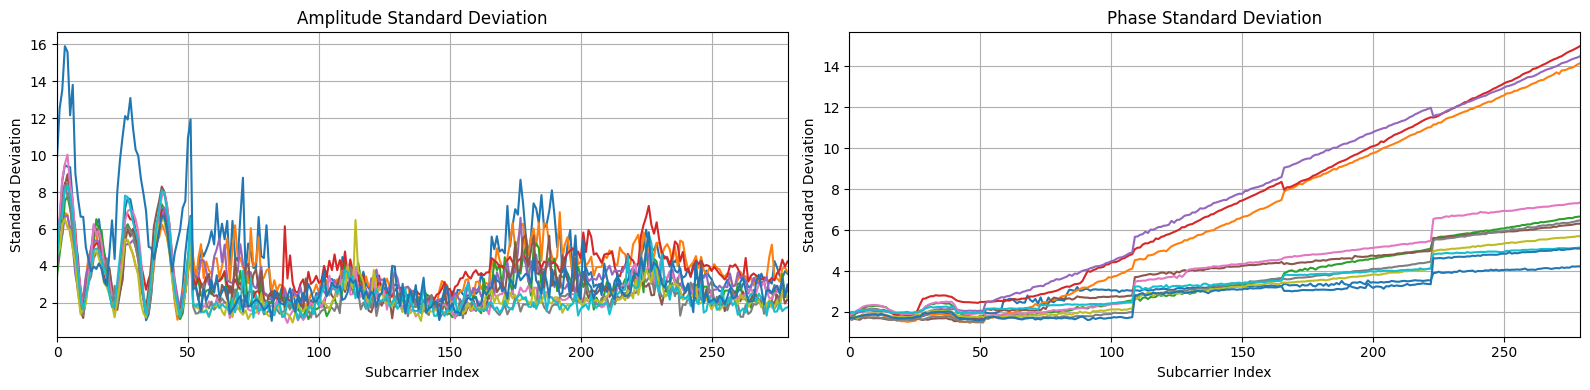

[1]


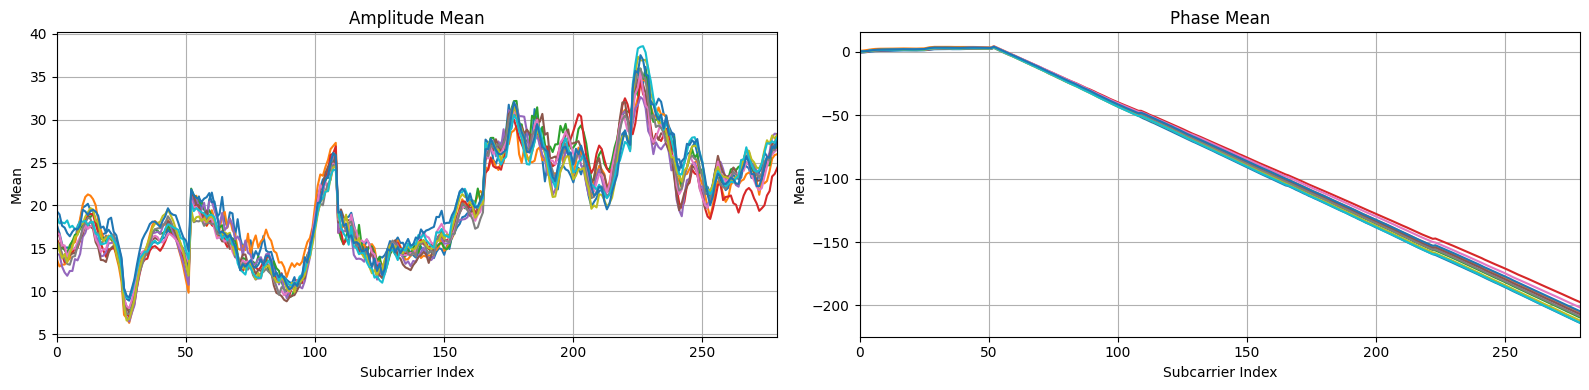

[1]


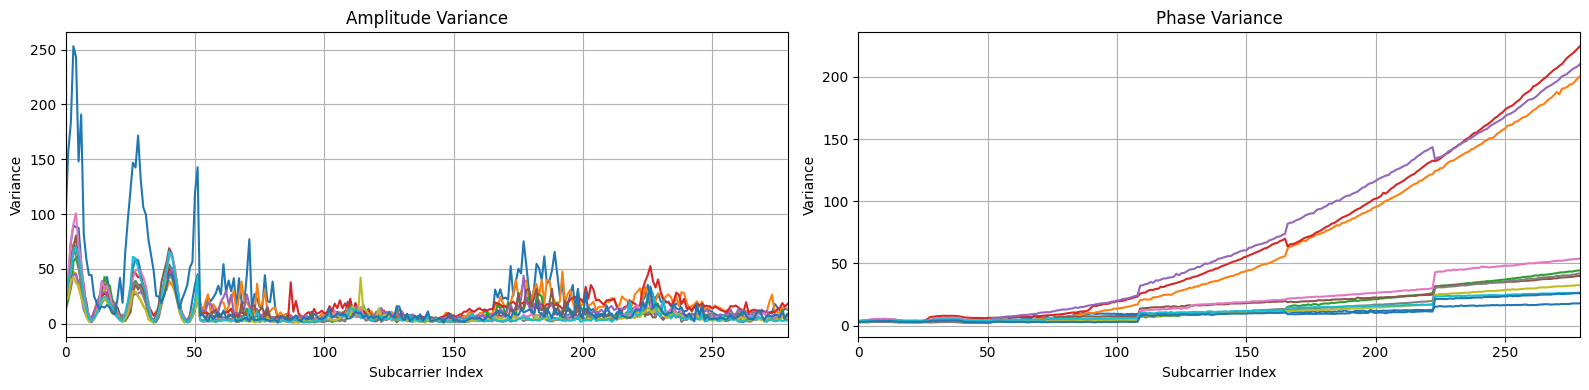

[1]


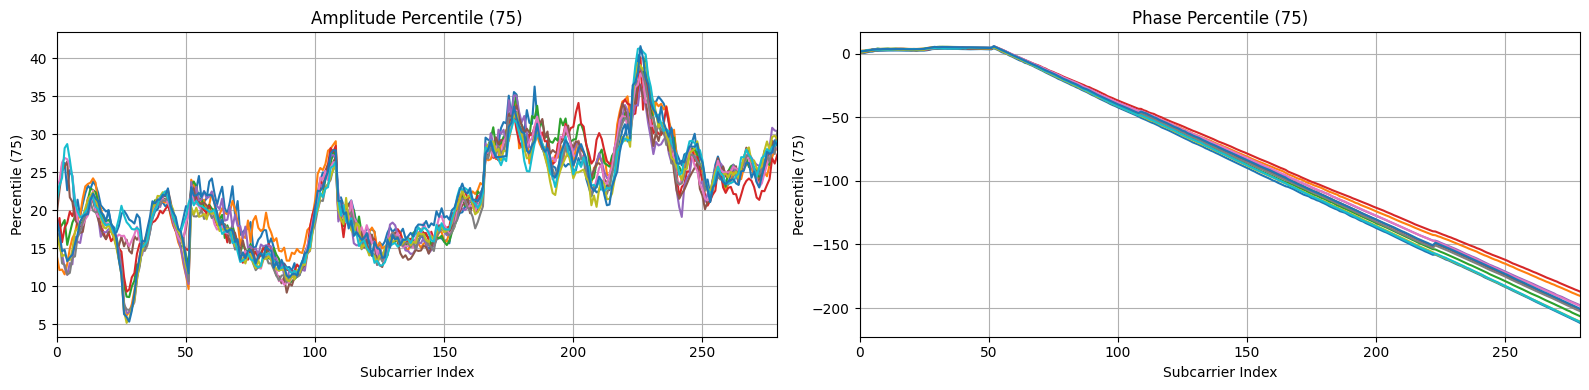

[1]


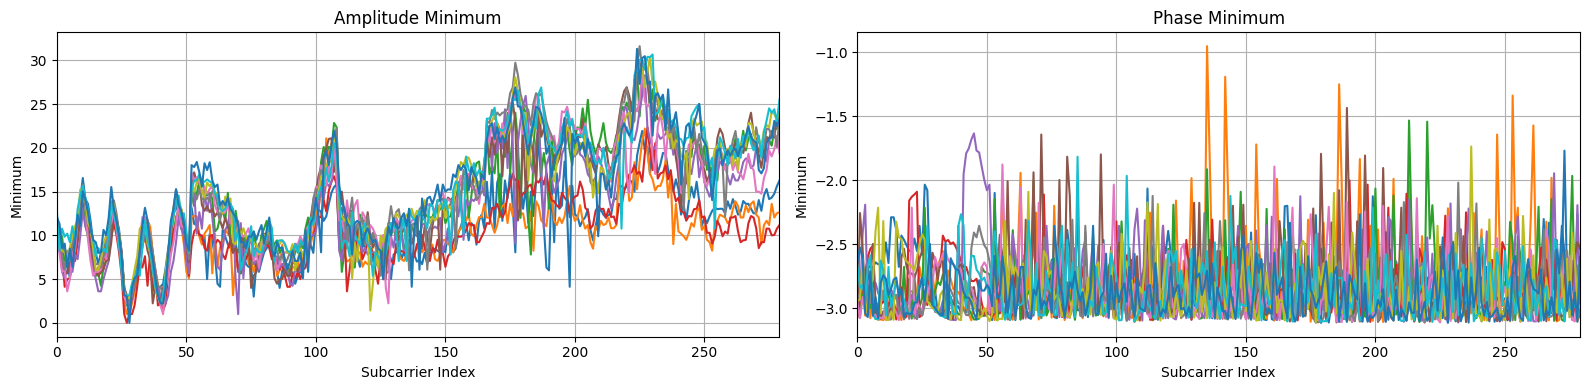

[1]


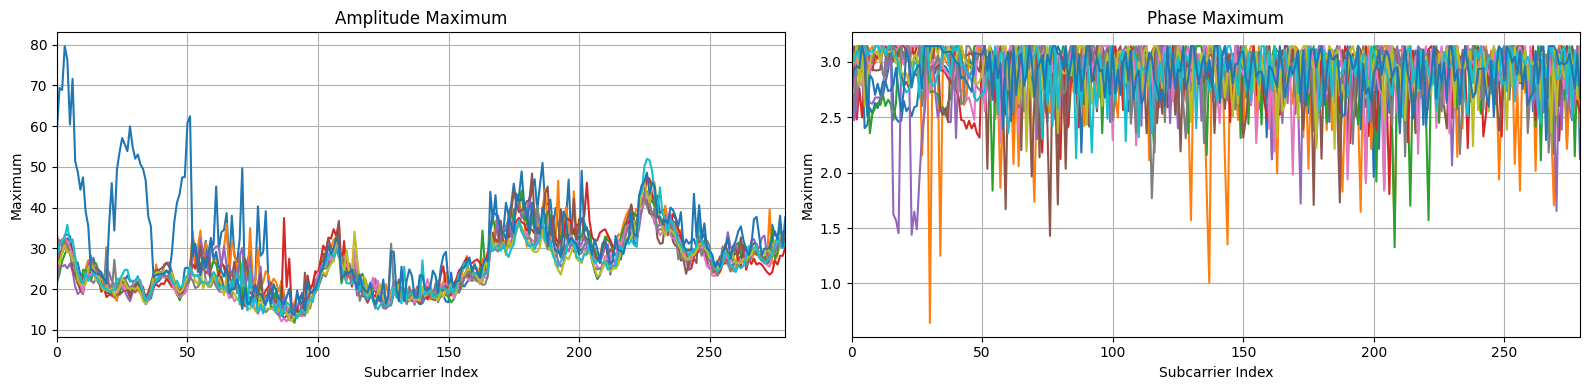

[1]


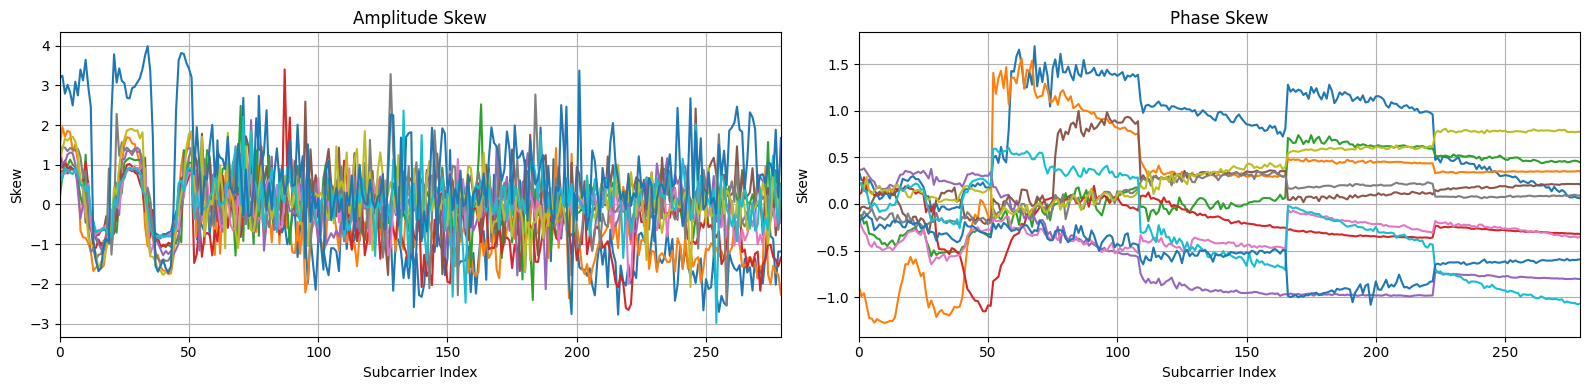

[1]


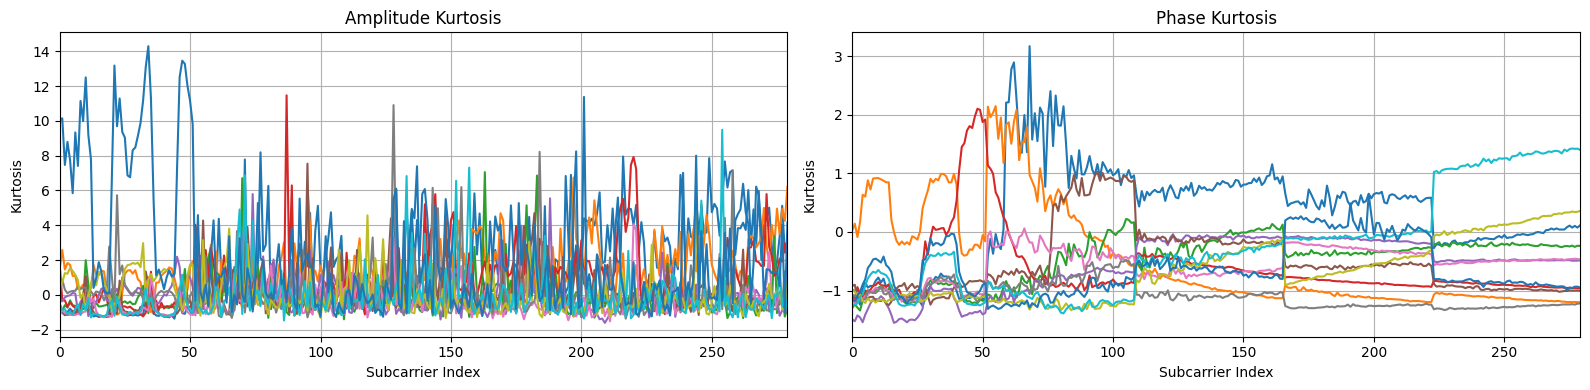

[1]


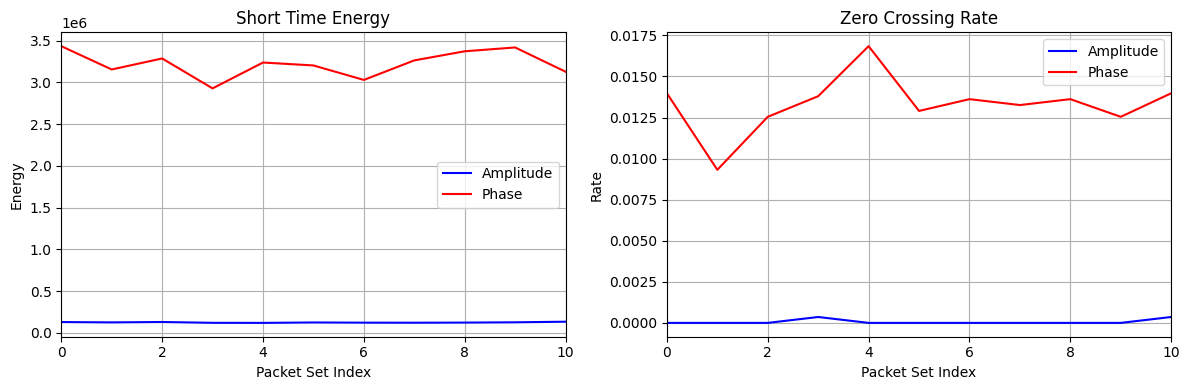

[1]


c:\Users\Jhondale\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 20, using nperseg = 20
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


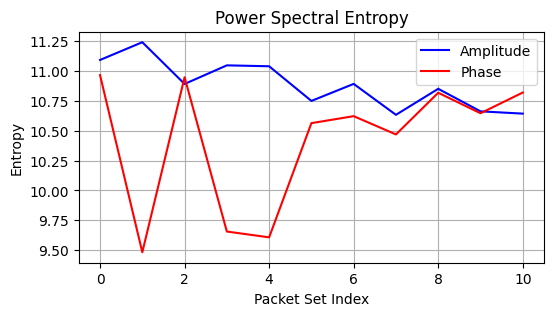

In [ ]:
FILE_PATH = '../dataset/batch/b1/CSI_DATA_023.csv'
visualize_csi_standard_deviation(FILE_PATH, True)
visualize_csi_mean(FILE_PATH, True)
visualize_csi_variance(FILE_PATH, True)
visualize_csi_percentile(FILE_PATH, 75, True)
visualize_csi_min(FILE_PATH)
visualize_csi_max(FILE_PATH)
visualize_csi_skew(FILE_PATH, True)
visualize_csi_kurtosis(FILE_PATH, True)
visualize_csi_ste_and_zcr(FILE_PATH, True)
visualize_csi_pow_spec_ent(FILE_PATH, True, 1.0, 256)

Dist: [1] Angle: [-15]


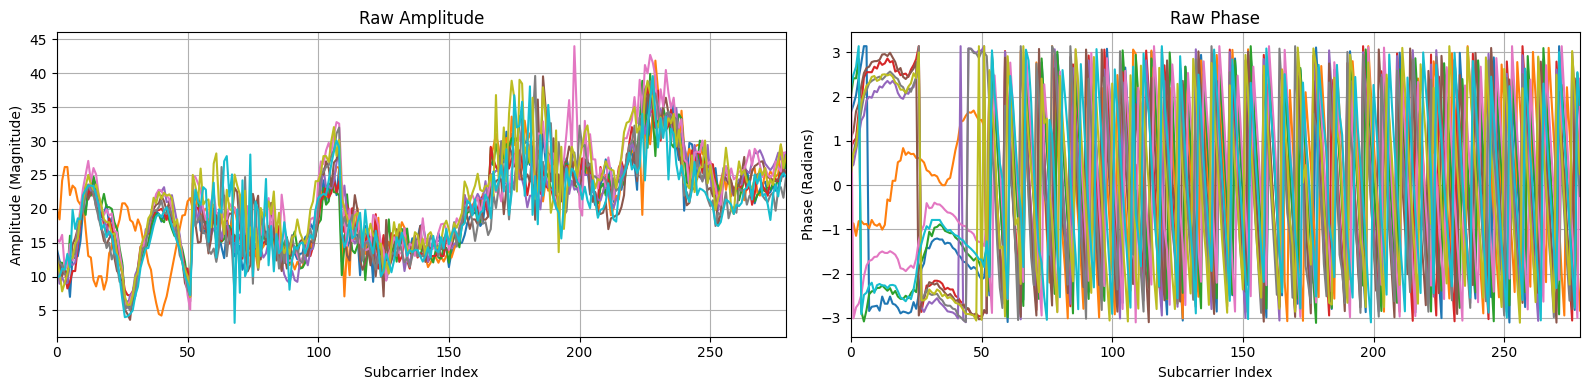

Dist: [1] Angle: [-15]


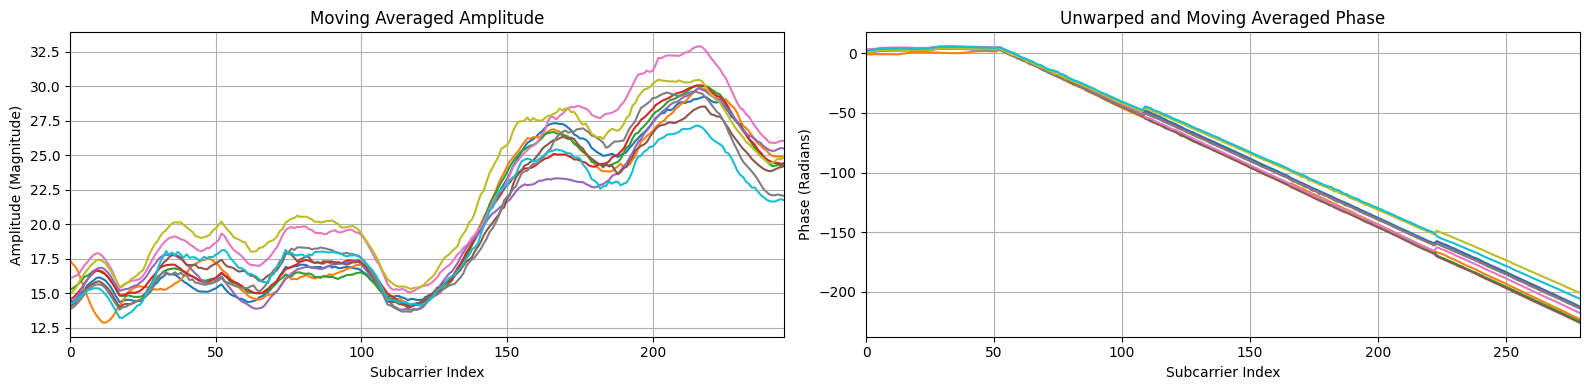

Dist: [1] Angle: [-15]


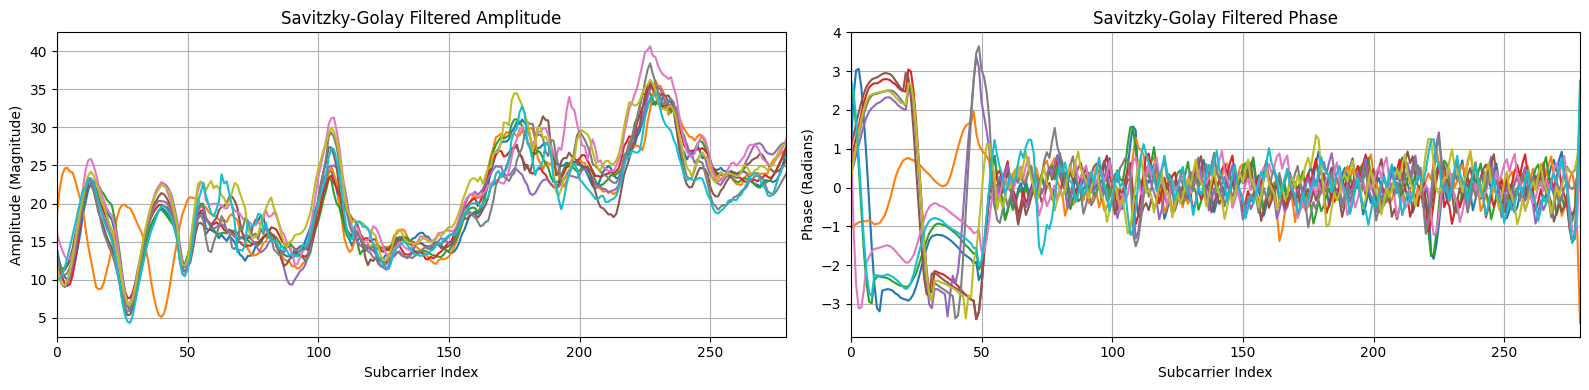

Dist: [1] Angle: [-15]


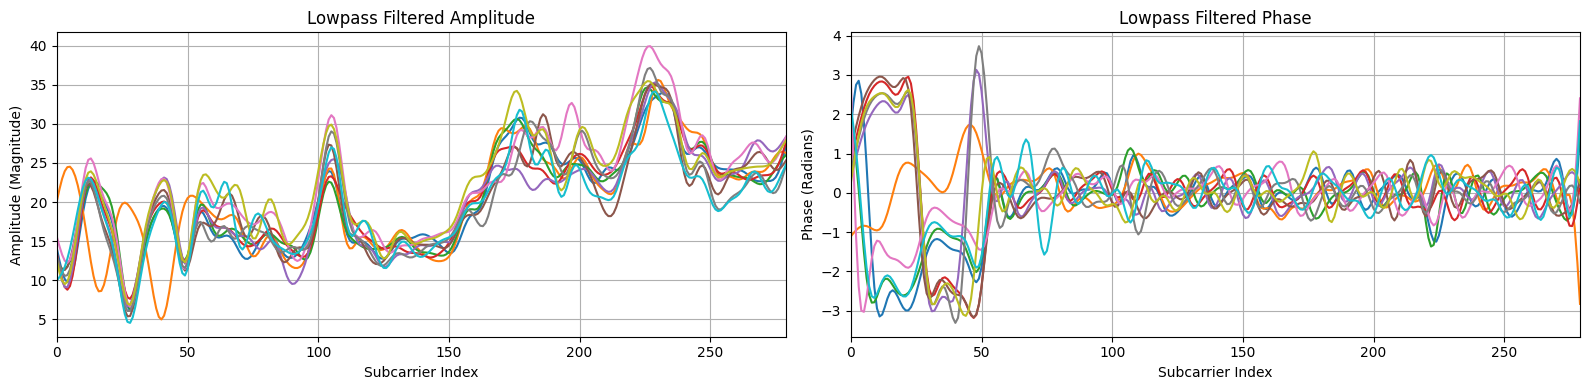

Dist: [1] Angle: [-15]


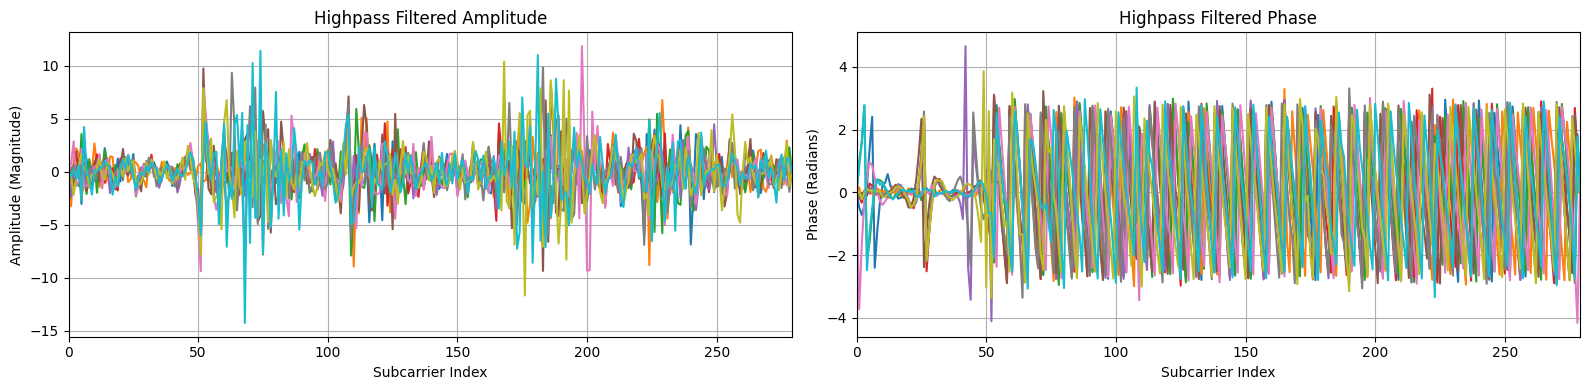

Dist: [1] Angle: [-15]


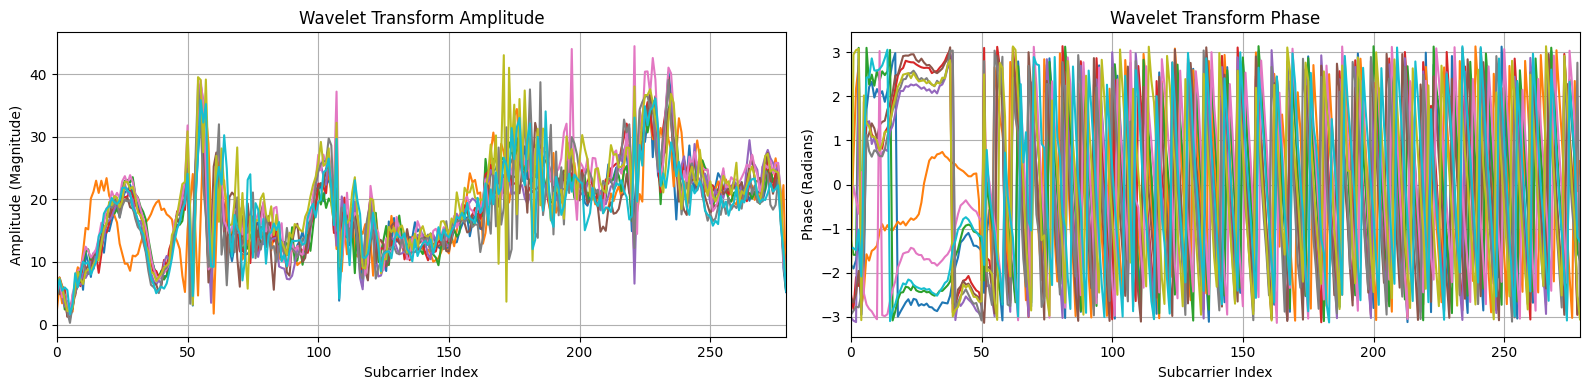

Dist: [1] Angle: [-15]


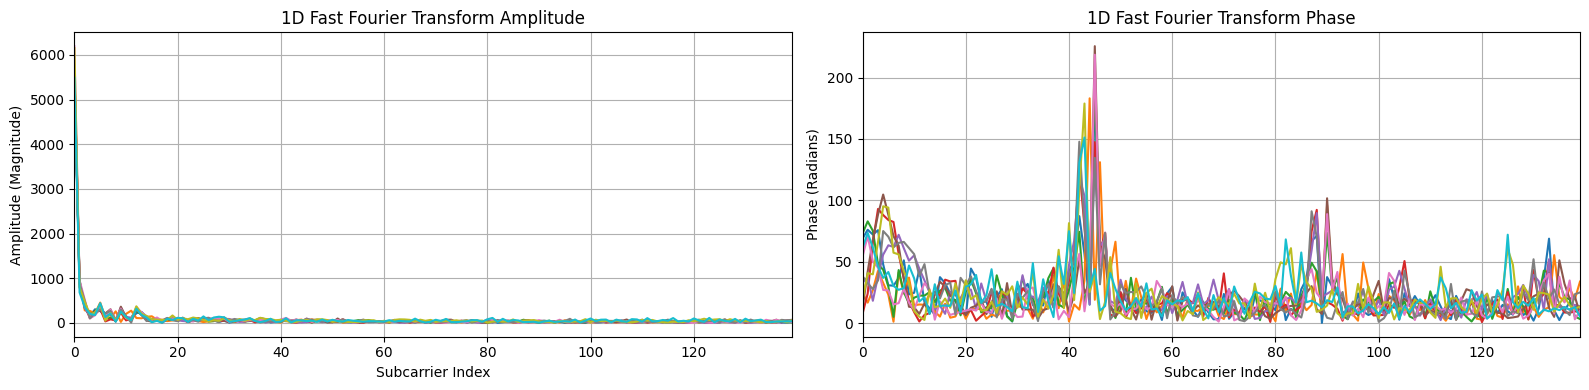

Dist: [1] Angle: [-15]


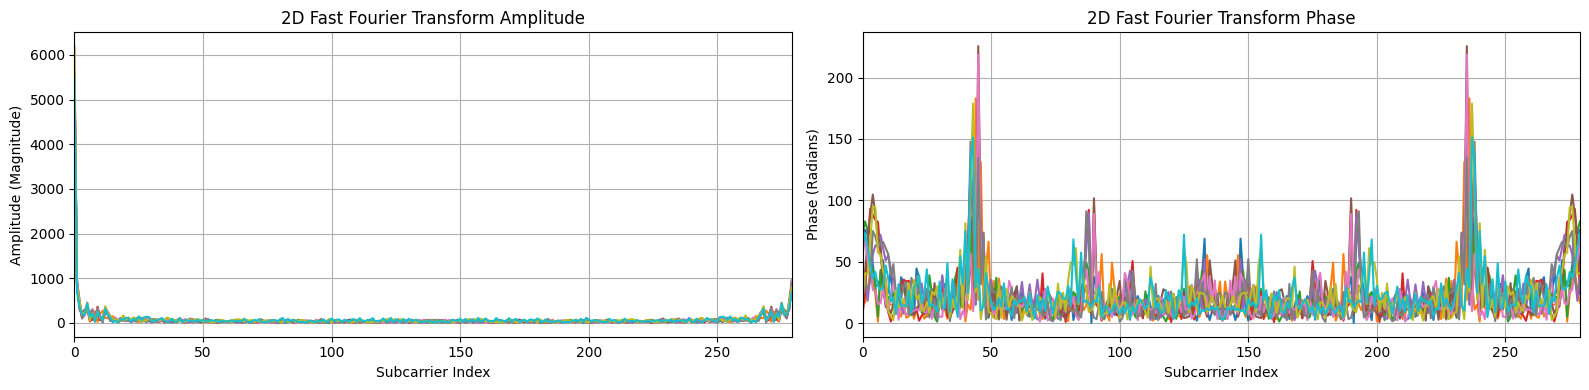

Dist: [1] Angle: [-15]


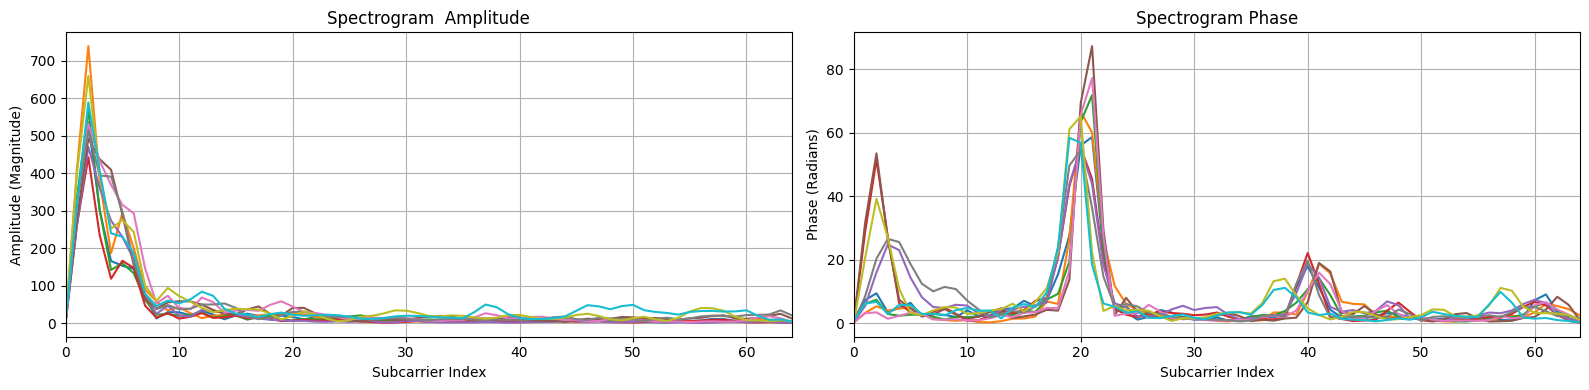

Dist: [1] Angle: [-15]


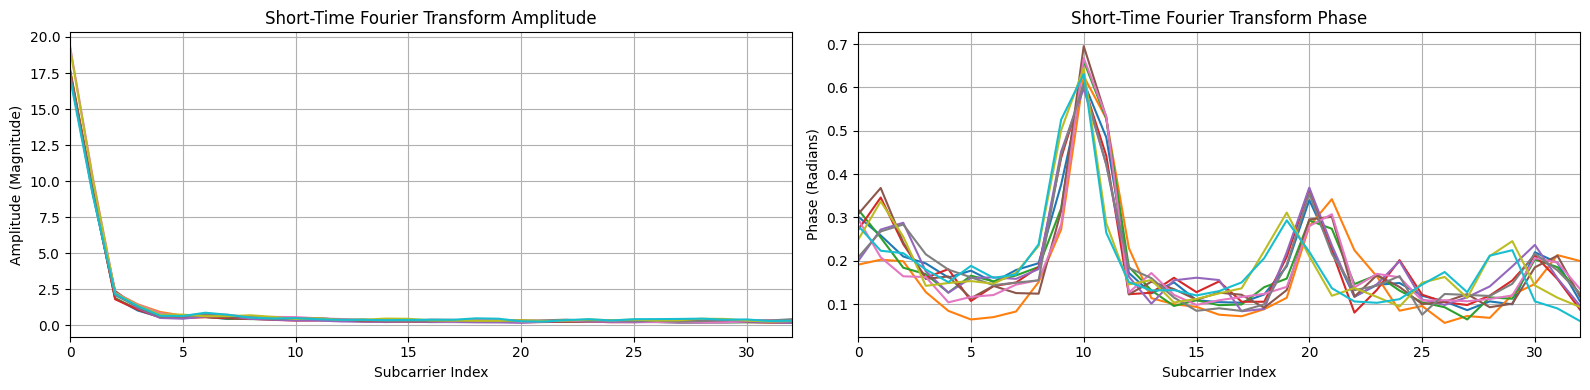

Dist: [1] Angle: [-15]


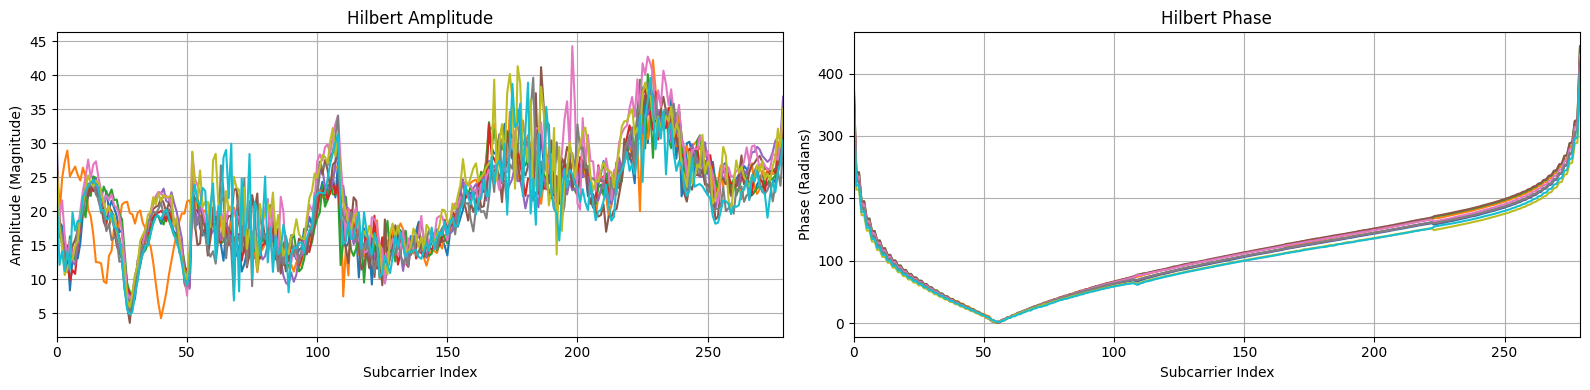

Dist: [1] Angle: [-15]


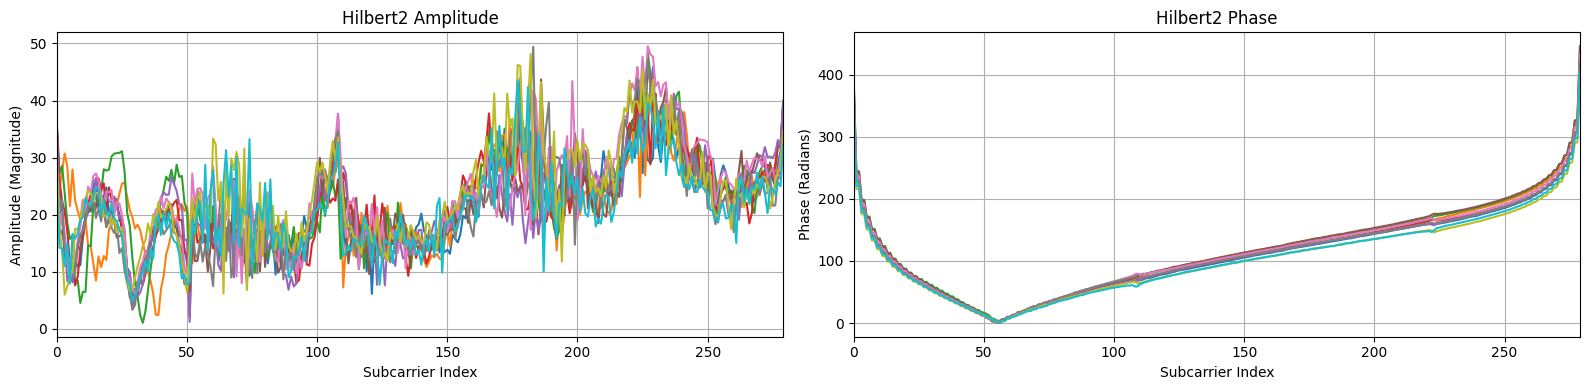

Dist: [1] Angle: [-15]


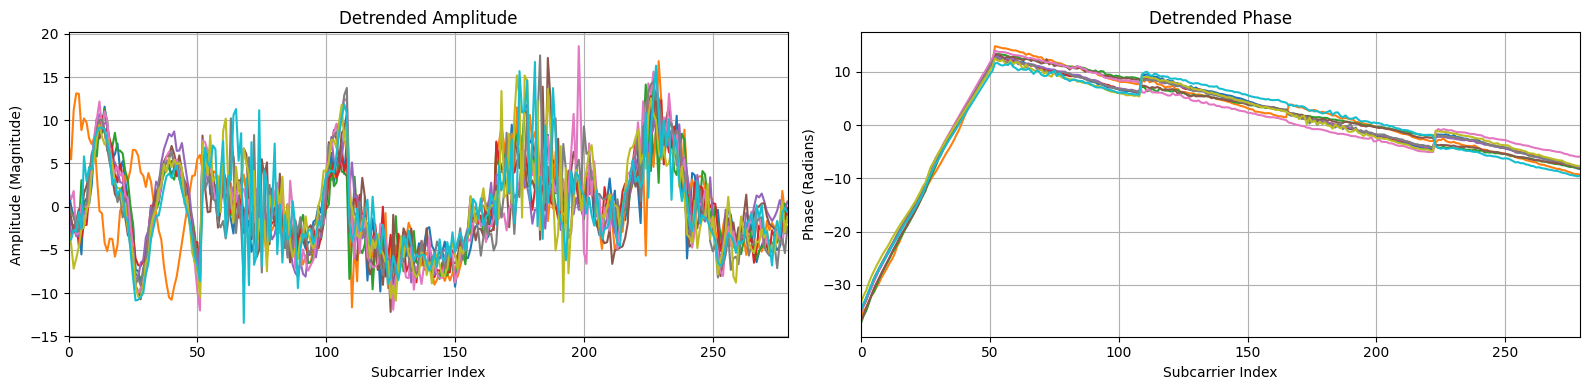

In [45]:
FILE_PATH = '../dataset/batch/b1/CSI_DATA_023.csv'
visualize_csi_raw(FILE_PATH)
visualize_csi_upwrap_averaged(FILE_PATH, True, 35, 1)
visualize_csi_savgol_filter(FILE_PATH, 11, 3)
visualize_csi_lowpass_filter(FILE_PATH, 0.1, 1, 5)
visualize_csi_highpass_filter(FILE_PATH, 0.1, 1, 5)
visualize_csi_wavelet_transform(FILE_PATH, 'db3', 3, 'db1')
visualize_csi_fast_fourier_trans_1d(FILE_PATH)
visualize_csi_fast_fourier_trans_2d(FILE_PATH)
visualize_csi_spectrogram(FILE_PATH)
visualize_csi_short_time_four_trans(FILE_PATH)
visualize_csi_hilbert(FILE_PATH)
visualize_csi_hilbert2(FILE_PATH)
visualize_csi_detrend(FILE_PATH)